# APM466 Assignment 1

You will need `bond_data.csv` in order for this file to run. You can generate this file by running every cell in `data_download.ipynb`.

In [263]:
from collections import namedtuple
from datetime import date, datetime

import numpy as np
import pandas as pd

BondTimeSeries = namedtuple(
    "BondTimeSeries",
    ["name", "isin", "coupon", "date_issue", "date_maturity", "time_series"],
)

target_dates = pd.date_range("2025-01-06", periods=10, freq="B").strftime("%Y-%m-%d %H:%M").tolist()
target_dates

['2025-01-06 00:00',
 '2025-01-07 00:00',
 '2025-01-08 00:00',
 '2025-01-09 00:00',
 '2025-01-10 00:00',
 '2025-01-13 00:00',
 '2025-01-14 00:00',
 '2025-01-15 00:00',
 '2025-01-16 00:00',
 '2025-01-17 00:00']

In [264]:
bonds = []

# Read the bond data from CSV file
bond_data = pd.read_csv("bond_data.csv")
for index, row in bond_data.iterrows():
    name = row["Name"]
    time_series = {key: row[key] for key in target_dates}
    bonds.append(
        BondTimeSeries(
            name=row["Name"],
            isin=row["ISIN"],
            coupon=row["Coupon"],
            date_issue=datetime.strptime(row["Issue Date"], "%Y-%m-%d").date(),
            date_maturity=datetime.strptime(row["Maturity Date"], "%Y-%m-%d").date(),
            time_series=time_series,
        )
    )

bonds

[BondTimeSeries(name='CAN 1.25 Mar 25', isin='CA135087K528', coupon=0.0125, date_issue=datetime.date(2019, 10, 11), date_maturity=datetime.date(2025, 3, 1), time_series={'2025-01-06 00:00': 99.73, '2025-01-07 00:00': 99.73, '2025-01-08 00:00': 99.74, '2025-01-09 00:00': 99.73, '2025-01-10 00:00': 99.74, '2025-01-13 00:00': 99.73, '2025-01-14 00:00': 99.73, '2025-01-15 00:00': 99.77, '2025-01-16 00:00': 99.78, '2025-01-17 00:00': 99.8}),
 BondTimeSeries(name='CAN 0.50 Sep 25', isin='CA135087K940', coupon=0.005, date_issue=datetime.date(2020, 4, 3), date_maturity=datetime.date(2025, 9, 1), time_series={'2025-01-06 00:00': 98.4, '2025-01-07 00:00': 98.41, '2025-01-08 00:00': 98.4, '2025-01-09 00:00': 98.42, '2025-01-10 00:00': 98.37, '2025-01-13 00:00': 98.36, '2025-01-14 00:00': 98.36, '2025-01-15 00:00': 98.4, '2025-01-16 00:00': 98.47, '2025-01-17 00:00': 98.5}),
 BondTimeSeries(name='CAN 4.50 Feb 26', isin='CA135087R226', coupon=0.045, date_issue=datetime.date(2023, 11, 1), date_matur

In [265]:
BondObservation = namedtuple(
    "BondObservation",
    ["name", "coupon", "date_issue", "date_maturity", "date_observation", "price"],
)


def get_observations_for_date(d: date) -> list[BondObservation]:
    observations = []
    for bond in bonds:
        obs = BondObservation(
            name=bond.name,
            coupon=bond.coupon,
            date_issue=bond.date_issue,
            date_maturity=bond.date_maturity,
            date_observation=d,
            price=bond.time_series[d.strftime("%Y-%m-%d 00:00")],
        )
        observations.append(obs)
    return observations

In [266]:
def get_bond_cashflows(bond: BondObservation, valuation_date: date) -> tuple[list[float], list[date]]:
    # Determine the bond's cash flows and their dates
    cfs_to_maturity = []
    cf_dates = []
    test_date = bond.date_maturity - relativedelta(months=60)
    while test_date <= bond.date_maturity:
        if valuation_date < test_date < bond.date_maturity:
            cfs_to_maturity.append(100 * (bond.coupon / 2))
            cf_dates.append(test_date)
        if test_date == bond.date_maturity:
            cfs_to_maturity.append(100 * (bond.coupon / 2 + 1))
            cf_dates.append(test_date)
        test_date += relativedelta(months=6)
    # Sanity Checks
    assert len(cfs_to_maturity) > 0, f"No cash flows for bond [{bond.name}]"
    assert len(cfs_to_maturity) == len(cf_dates), f"Number of cash flows and dates do not match for bond [{bond.name}]"
    assert cf_dates[-1] == bond.date_maturity, f"Last cash flow date does not match maturity date for bond [{bond.name}]"
    return cfs_to_maturity, cf_dates

### Calculate each bond's ytm

In [267]:
def year_fraction(start_date: date, end_date: date) -> float:
    return (end_date - start_date).days / 365.0

In [268]:
MaturityYield = namedtuple("MaturityYield", ["years_to_maturity", "yield_to_maturity"])


def newton_ytm(
    bond: BondObservation,
    valuation_date: date,
    guess=0.03,
    tol=1e-6,
    max_iter=100,
) -> float:
    price = bond.time_series[valuation_date.strftime("%Y-%m-%d 00:00")]
    cfs_to_maturity, cf_dates = get_bond_cashflows(bond, valuation_date)

    def bond_price(ytm: float) -> float:
        pv = 0
        for i in range(len(cfs_to_maturity)):
            pv += cfs_to_maturity[i] / ((1 + (ytm / 2)) ** (2 * year_fraction(valuation_date, cf_dates[i])))
        return pv

    def bond_price_derivative(ytm: float) -> float:
        pv = 0
        for i in range(len(cfs_to_maturity)):
            t = year_fraction(valuation_date, cf_dates[i])
            pv += -(2 * t) * cfs_to_maturity[i] / ((1 + (ytm / 2)) ** (2 * t + 1))
        return pv

    last_coupon_date_before_obs = cf_dates[0] - relativedelta(months=6)
    days_since_last_coupon = (valuation_date - last_coupon_date_before_obs).days
    accrued_coupon = (days_since_last_coupon / (182.5)) * (100 * bond.coupon / 2)
    dirty_price = price + accrued_coupon

    ytm = guess
    for _ in range(max_iter):
        price_diff = bond_price(ytm) - dirty_price
        if abs(price_diff) < tol:
            return ytm
        ytm -= price_diff / bond_price_derivative(ytm)
    return ytm


def get_ytms_for_date(target_datetime: str) -> list[MaturityYield]:
    ytms = []
    for bond in bonds:
        target_date = datetime.strptime(target_datetime, "%Y-%m-%d 00:00").date()
        years_to_maturity = year_fraction(target_date, bond.date_maturity)
        ytm = newton_ytm(bond, target_date)
        ytms.append(MaturityYield(years_to_maturity, ytm))
    return ytms


print(*get_ytms_for_date("2025-01-06 00:00"), sep="\n")

MaturityYield(years_to_maturity=0.14794520547945206, yield_to_maturity=0.03121600387462091)
MaturityYield(years_to_maturity=0.6520547945205479, yield_to_maturity=0.029955887905691245)
MaturityYield(years_to_maturity=1.0712328767123287, yield_to_maturity=0.029711889553588642)
MaturityYield(years_to_maturity=1.5726027397260274, yield_to_maturity=0.02988717518979196)
MaturityYield(years_to_maturity=2.147945205479452, yield_to_maturity=0.02886164275457191)
MaturityYield(years_to_maturity=2.652054794520548, yield_to_maturity=0.028953068462599693)
MaturityYield(years_to_maturity=3.1506849315068495, yield_to_maturity=0.028922505784368124)
MaturityYield(years_to_maturity=3.654794520547945, yield_to_maturity=0.029275529046974356)
MaturityYield(years_to_maturity=4.1506849315068495, yield_to_maturity=0.029515615852014395)
MaturityYield(years_to_maturity=4.654794520547945, yield_to_maturity=0.029832075229775025)
MaturityYield(years_to_maturity=5.1506849315068495, yield_to_maturity=0.03001392686729

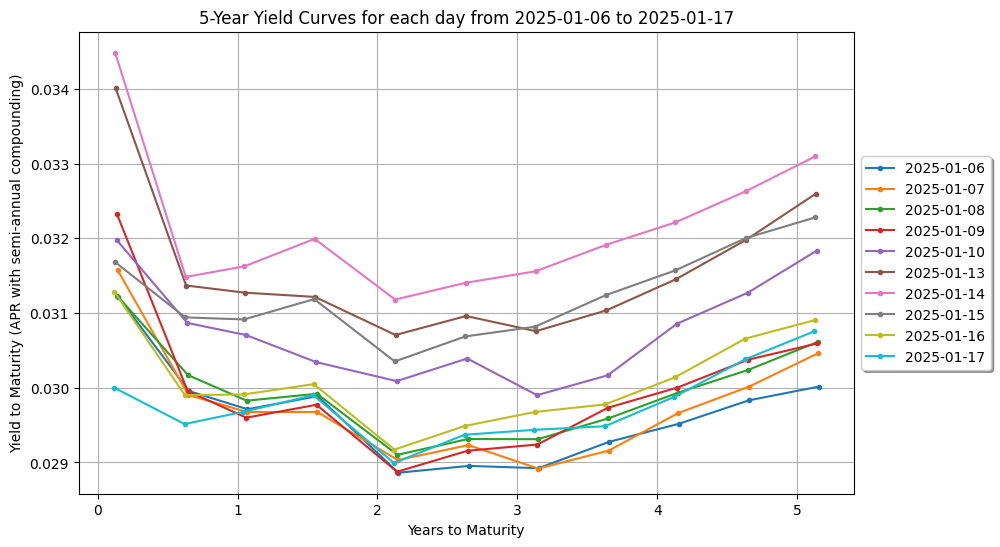

In [269]:
import matplotlib.pyplot as plt

yield_curves = [get_ytms_for_date(d) for d in target_dates]

plt.figure(figsize=(10, 6))

for curve, date_ in zip(yield_curves, target_dates):
    x = [ytm.years_to_maturity for ytm in curve]
    y = [ytm.yield_to_maturity for ytm in curve]
    plt.plot(x, y, marker="o", markersize=3, label=date_[:-6])

plt.xlabel("Years to Maturity")
plt.ylabel("Yield to Maturity (APR with semi-annual compounding)")
plt.title("5-Year Yield Curves for each day from 2025-01-06 to 2025-01-17")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Bootstrap the spot curve

In [270]:
# !pip install python-dateutil
from dateutil.relativedelta import relativedelta

In [271]:
SpotRate = namedtuple("SpotRate", ["date", "rate"])


def get_closest_spot_rate(spot_rates: list[SpotRate], target_date: date) -> SpotRate:
    closest_date = None
    closest_rate = None
    for spot_rate in spot_rates:
        if closest_date is None or abs(year_fraction(spot_rate.date, target_date)) < abs(year_fraction(closest_date, target_date)):
            closest_date = spot_rate.date
            closest_rate = spot_rate.rate
    return SpotRate(date=closest_date, rate=closest_rate)


def bootstrap_yield_curve(bonds: list[BondObservation], valuation_date: date) -> list[float]:
    bonds = sorted(bonds, key=lambda x: x.date_maturity)  # Sort by maturity date
    spot_rates = []

    for idx, bond in enumerate(bonds):
        assert bond.date_issue < valuation_date, f"Bond [{bond.name}] will be issued in the future"

        cfs_to_maturity, cf_dates = get_bond_cashflows(bond, valuation_date)
        assert len(cfs_to_maturity) == idx + 1
        assert len(cf_dates) == idx + 1

        # Calculate spot rates
        spot_rate = None
        years_to_maturity = year_fraction(valuation_date, bond.date_maturity)
        if idx == 0:
            # Calculate the very first (6-month) spot rate
            days_to_maturity = (bond.date_maturity - valuation_date).days
            last_coupon_date_before_obs = cf_dates[0] - relativedelta(months=6)
            days_since_last_coupon = (valuation_date - last_coupon_date_before_obs).days
            days_until_next_coupon = (cf_dates[0] - valuation_date).days
            accrued_coupon = (days_since_last_coupon / (days_since_last_coupon + days_until_next_coupon)) * (100 * bond.coupon / 2)
            dirty_price = bond.price + accrued_coupon
            spot_rate = ((cfs_to_maturity[0] / dirty_price) - 1) * (365 / days_to_maturity)
        else:
            # Bootstrap a spot rate from the previous spot rates
            pv_all_cf_but_last = sum(
                cf / ((1 + (get_closest_spot_rate(spot_rates, cf_date).rate / 2)) ** (2 * year_fraction(valuation_date, cf_date)))
                for cf, cf_date in zip(cfs_to_maturity[:-1], cf_dates[:-1])
            )
            spot_rate = (((cfs_to_maturity[-1] / (bond.price - pv_all_cf_but_last)) ** (1 / (2 * years_to_maturity))) - 1) * 2
        spot_rates.append(SpotRate(date=bond.date_maturity, rate=spot_rate))

    return spot_rates

In [272]:
valuation_date = date(2025, 1, 6)
bonds_data = get_observations_for_date(valuation_date)

spot_rates = bootstrap_yield_curve(bonds_data, valuation_date)
__import__("pprint").pprint(spot_rates)

[SpotRate(date=datetime.date(2025, 3, 1), rate=0.030801679269275368),
 SpotRate(date=datetime.date(2025, 9, 1), rate=0.03271386152565592),
 SpotRate(date=datetime.date(2026, 2, 1), rate=0.048574252416188735),
 SpotRate(date=datetime.date(2026, 8, 3), rate=0.041074961564882884),
 SpotRate(date=datetime.date(2027, 3, 1), rate=0.030904861640126846),
 SpotRate(date=datetime.date(2027, 9, 1), rate=0.03261140237678095),
 SpotRate(date=datetime.date(2028, 3, 1), rate=0.03283327900409905),
 SpotRate(date=datetime.date(2028, 9, 1), rate=0.032422316570953846),
 SpotRate(date=datetime.date(2029, 3, 1), rate=0.03293419392341557),
 SpotRate(date=datetime.date(2029, 9, 1), rate=0.032518114433759404),
 SpotRate(date=datetime.date(2030, 3, 1), rate=0.0319345280233847)]


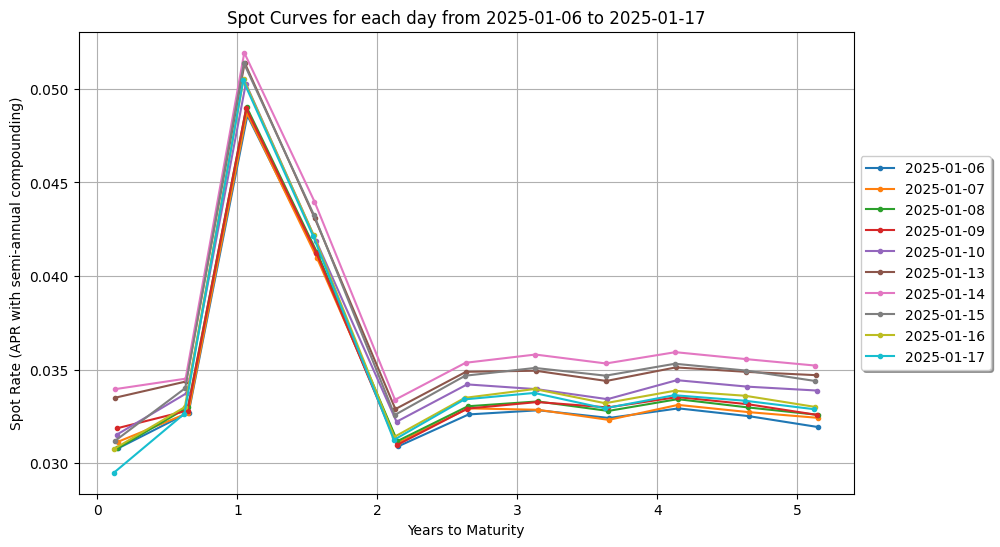

In [273]:
spot_curves = {}  # {date: [spot curve]}

plt.figure(figsize=(10, 6))

for date_ in target_dates:
    bonds_data = get_observations_for_date(datetime.strptime(date_, "%Y-%m-%d %H:%M").date())
    spot_rates = bootstrap_yield_curve(bonds_data, datetime.strptime(date_, "%Y-%m-%d %H:%M").date())
    spot_curves[date_] = spot_rates
    x = [year_fraction(datetime.strptime(date_, "%Y-%m-%d %H:%M").date(), spot_rate.date) for spot_rate in spot_rates]
    y = [spot_rate.rate for spot_rate in spot_rates]
    plt.plot(x, y, marker="o", markersize=3, label=date_[:-6])

plt.xlabel("Years to Maturity")
plt.ylabel("Spot Rate (APR with semi-annual compounding)")
plt.title("Spot Curves for each day from 2025-01-06 to 2025-01-17")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True)
plt.grid(True)
plt.show()

### Compute Forward Rates

In [274]:
from scipy.interpolate import interp1d


def interpolate_spot_ears_from_aprs(spot_rates: list[SpotRate], target_years: list[int]) -> list[float]:
    years = [year_fraction(valuation_date, sr.date) for sr in spot_rates]
    ears = [((1 + sr.rate / 2) ** 2) - 1 for sr in spot_rates]
    # Linearly interpolate the spot effective annual rates for the target years
    interpolation_function = interp1d(years, ears, kind="linear", fill_value="extrapolate")
    return interpolation_function(target_years)


target_years = [1, 2, 3, 4, 5]
interpolate_spot_ears_from_aprs(spot_curves[target_dates[0]], target_years)

array([0.04641411, 0.03380587, 0.03303464, 0.03304727, 0.03236967])

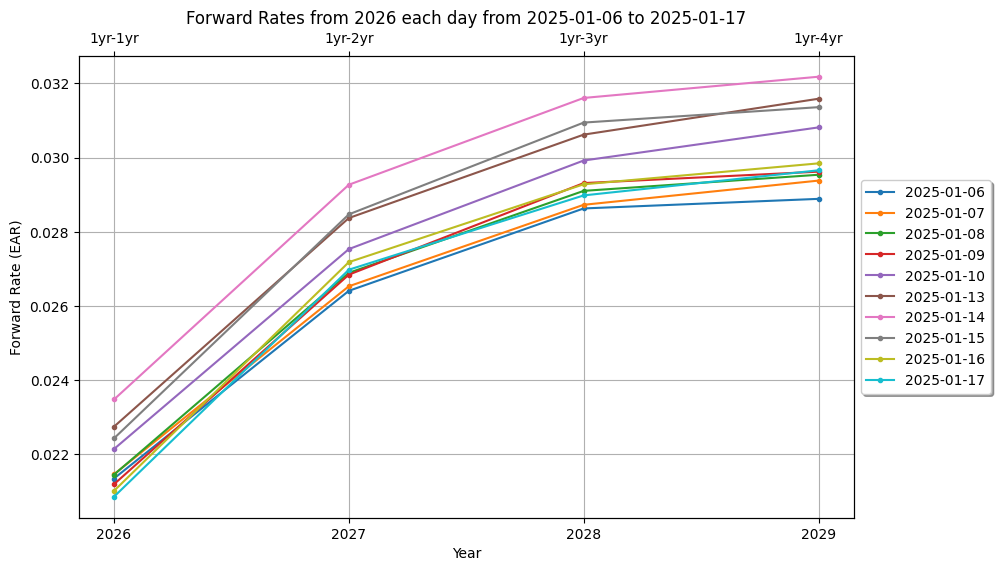

In [275]:
fig, ax1 = plt.subplots(figsize=(10, 6))

forward_rates = np.zeros((4, len(target_dates)))

for date_idx, date_ in enumerate(target_dates):
    interpolated_spot_ears = interpolate_spot_ears_from_aprs(spot_curves[date_], target_years)
    for i in range(1, 5):
        forward_rates[i - 1, date_idx] = (((1 + interpolated_spot_ears[i]) ** (i + 1)) / ((1 + interpolated_spot_ears[0]) ** 1)) ** (1 / i) - 1
    ax1.plot(
        [x + 2025 for x in target_years[:-1]],
        forward_rates[:, date_idx],
        marker="o",
        markersize=3,
        label=date_[:-6],
    )

ax1.set_xlabel("Year")
ax1.set_xticks(range(2026, 2030))
ax1.set_ylabel("Forward Rate (EAR)")
ax1.set_title("Forward Rates from 2026 each day from 2025-01-06 to 2025-01-17")
ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5), ncol=1, fancybox=True, shadow=True)
ax1.grid(True)

# Create a second x-axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks([2026, 2027, 2028, 2029])
ax2.set_xticklabels(["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"])

plt.show()

### Calculate Covariance Matrices for Daily Log-Returns of Yield and Forward Rates

#### Compute Covariance Matrix of the daily log-return of yield:

In [276]:
# Interpolate ytms for each target year
target_years = [1, 2, 3, 4, 5]

# yield_for_year[i, j] = yield for target_years[i] on target_dates[j]
yield_for_year = np.zeros((len(target_years), len(target_dates)))

for i, curve in enumerate(yield_curves):
    years = [ytm.years_to_maturity for ytm in curve]
    yields = [ytm.yield_to_maturity for ytm in curve]
    interpolation_function = interp1d(years, yields, kind="linear", fill_value="extrapolate")
    yield_for_year[:, i] = interpolation_function(target_years)

yield_for_year

array([[0.02975335, 0.02971172, 0.02988007, 0.02965249, 0.03072895,
        0.03128487, 0.03160859, 0.03091725, 0.02990853, 0.02966129],
       [0.02912535, 0.02919351, 0.02930373, 0.02909239, 0.03014894,
        0.03082001, 0.03135852, 0.03053035, 0.02935525, 0.02917831],
       [0.02893174, 0.02901078, 0.02931113, 0.02921562, 0.03003756,
        0.03081045, 0.03151907, 0.03078411, 0.02962846, 0.02942015],
       [0.02944266, 0.02951055, 0.0298316 , 0.02992427, 0.03066243,
        0.03134178, 0.03213598, 0.0314856 , 0.03004789, 0.02978182],
       [0.02995867, 0.03032793, 0.03050342, 0.03053027, 0.03167748,
        0.03243543, 0.0329782 , 0.03220938, 0.03084291, 0.03066404]])

In [277]:
ytm_log_return_for_day = np.zeros((len(target_years), len(target_dates) - 1))

for i in range(len(target_years)):
    for j in range(len(target_dates) - 1):
        ytm_log_return_for_day[i, j] = np.log(yield_for_year[i, j + 1] / yield_for_year[i, j])

# Calculate the covariance matrix of ytm_log_return_for_day
covariance_matrix = np.cov(ytm_log_return_for_day)
covariance_matrix

array([[0.00043107, 0.00048289, 0.0004517 , 0.00045424, 0.00049185],
       [0.00048289, 0.0005528 , 0.00052304, 0.00053025, 0.0005664 ],
       [0.0004517 , 0.00052304, 0.00051198, 0.00052771, 0.00053807],
       [0.00045424, 0.00053025, 0.00052771, 0.00056241, 0.00055703],
       [0.00049185, 0.0005664 , 0.00053807, 0.00055703, 0.00059859]])

In [278]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues:
 [2.58926926e-03 4.64679967e-05 1.51878286e-05 4.73501144e-06
 1.18438279e-06]
Eigenvectors:
 [[-0.3996084   0.55236686  0.31753593  0.62142553  0.21955689]
 [-0.45926182  0.32695041  0.14406695 -0.4117707  -0.70133559]
 [-0.44162489 -0.23515144  0.4360563  -0.49570322  0.56018254]
 [-0.45557019 -0.71875615  0.02054286  0.43772113 -0.28952305]
 [-0.47625094  0.12683719 -0.82936635 -0.08338907  0.24958984]]


#### Compute covariance matrix for daily log-return of forward rates:

In [279]:
forward_rates

array([[0.02134954, 0.02146435, 0.02145312, 0.02119521, 0.02214428,
        0.02274733, 0.02348026, 0.02243219, 0.02101649, 0.02085842],
       [0.02640919, 0.02653165, 0.02689384, 0.02684488, 0.027534  ,
        0.02837147, 0.02926899, 0.02847049, 0.02718276, 0.02697834],
       [0.02862971, 0.02872809, 0.02910349, 0.02931314, 0.02992179,
        0.03061973, 0.03160844, 0.03094428, 0.02928041, 0.02898134],
       [0.02888811, 0.02938045, 0.02953796, 0.02962156, 0.03081456,
        0.03158706, 0.03218061, 0.03136005, 0.02984509, 0.02965819]])

In [280]:
fwd_log_return_for_day = np.zeros((4, len(target_dates) - 1))

for i in range(4):
    for j in range(len(target_dates) - 1):
        fwd_log_return_for_day[i, j] = np.log(forward_rates[i, j + 1] / forward_rates[i, j])

# Calculate the covariance matrix of fwd_log_return_for_day
covariance_matrix = np.cov(fwd_log_return_for_day)
covariance_matrix

array([[0.00126916, 0.00091691, 0.00089176, 0.0009452 ],
       [0.00091691, 0.00070408, 0.00069681, 0.00068242],
       [0.00089176, 0.00069681, 0.00072379, 0.00067945],
       [0.0009452 , 0.00068242, 0.00067945, 0.00074028]])

In [281]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
print("Eigenvalues:\n", eigenvalues)
print("Eigenvectors:\n", eigenvectors)

Eigenvalues:
 [3.32506844e-03 7.70504516e-05 2.89897383e-05 6.20063094e-06]
Eigenvectors:
 [[ 0.6118261   0.47112558  0.46282295  0.43532107]
 [ 0.45480125 -0.32699318  0.40913867 -0.72030329]
 [ 0.45243884 -0.71583261 -0.28924389  0.44634152]
 [ 0.46273506  0.39837148 -0.73125812 -0.30403616]]
